# RLCT Estimation of MNIST

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/timaeus-research/devinterp/blob/main/examples/mnist.ipynb)

This Jupyter Notebook aims to reproduce the results of Lau et al. (2023) by measuring the Real Log Canonical Threshold (RLCT) for a small 2-layer ReLU model (about 1M parameters) trained on the MNIST dataset. It uses both Stochastic Gradient Nose-Hoover Thermostat (SGNHT) and Stochastic Gradient Langevin Dynamics (SGLD) as sampling methods.

## Main Steps:

1. **Data Preparation**: Load the MNIST dataset for training and testing.
2. **Model Training**: Train a multi-layer perceptron model using stochastic gradient descent.
3. **Model Evaluation**: Evaluate the model's performance on a test set.
4. **RLCT Estimation**: Use SGNHT and SGLD samplers to estimate RLCT.
5. **Plotting**: Visualize train and test losses, and RLCT estimates.

In [1]:
%pip install devinterp seaborn torchvision
!git clone https://github.com/ucla-vision/entropy-sgd.git
%cd entropy-sgd
from python.optim import EntropySGD  
%cd ..



Cloning into 'entropy-sgd'...
remote: Enumerating objects: 89, done.
remote: Total 89 (delta 0), reused 0 (delta 0), pack-reused 89
Receiving objects: 100% (89/89), 25.33 KiB | 498.00 KiB/s, done.
Resolving deltas: 100% (51/51), done.
/home/will/Kaggle/important/Timaeus/devinterp/examples/entropy-sgd
/home/will/Kaggle/important/Timaeus/devinterp/examples


In [2]:
import copy
import matplotlib.pyplot as plt

import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

from devinterp.optim.sgld import SGLD
from devinterp.optim.sgnht import SGNHT

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

PRIMARY, SECONDARY, TERTIARY, QUATERNARY = sns.color_palette("muted")[:4]
PRIMARY_LIGHT, SECONDARY_LIGHT, TERTIARY_LIGHT, QUATERNARY_LIGHT = sns.color_palette(
    "pastel"
)[:4]

In [3]:
def emtpy_func():
    return (), ()


def train_one_epoch(model, train_loader, optimizer, criterion, model_key):
    model.train()
    train_loss = 0
    for data, target in tqdm(train_loader):
        optimizer.zero_grad()
        output = model(data.to(DEVICE))
        loss = criterion(output, target.to(DEVICE))
        train_loss += loss.item()
        loss.backward()
        if model_key == "sgd":
            optimizer.step()
        else:
            optimizer.step(emtpy_func, model, criterion)
    return train_loss / len(train_loader)


def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data.to(DEVICE))
            loss = criterion(output, target.to(DEVICE))
            test_loss += loss.item()
    return test_loss / len(test_loader)


# Define the neural network
class Net(nn.Module):
    def __init__(
        self,
        hidden_layer_sizes=[1024, 1024],
        input_dim=28 * 28,
        output_dim=10,
        activation=F.relu,
        with_bias=True,
    ):
        super(Net, self).__init__()
        self.input_dim = input_dim
        self.layer_sizes = [input_dim] + hidden_layer_sizes + [output_dim]
        self.activation = activation
        self.with_bias = with_bias
        self.layers = nn.ModuleList()
        for i in range(len(self.layer_sizes) - 1):
            dim_in, dim_out = self.layer_sizes[i : i + 2]
            self.layers.append(nn.Linear(dim_in, dim_out, bias=self.with_bias).float())

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        x = self.layers[-1](x)
        return x

In [4]:
# Constants
DEVICE = "cuda"
BATCH_SIZE = 512
LR = 0.05
MOMENTUM = 0.9
N_EPOCHS = 10
DATA_PATH = "../data"


# Load MNIST dataset
def load_mnist_data(train, batch_size, shuffle):
    dataset = datasets.MNIST(
        DATA_PATH, train=train, transform=transforms.ToTensor(), download=True
    )
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)


train_loader = load_mnist_data(train=True, batch_size=BATCH_SIZE, shuffle=True)
test_loader = load_mnist_data(train=False, batch_size=BATCH_SIZE, shuffle=False)

model_esgd = Net().to(DEVICE)
model_sgd = Net().to(DEVICE)
optimizer_esgd = EntropySGD(
    model_esgd.parameters(), config=dict(lr=LR, momentum=MOMENTUM, L=5)
)
optimizer_sgd = optim.SGD(
    model_sgd.parameters(), lr=LR, momentum=MOMENTUM, nesterov=True
)

criterion = nn.CrossEntropyLoss()

In [5]:
train_losses, test_losses, models_saved = {}, {}, {}
for model_key, model, optimizer in [
    ("esgd", model_esgd, optimizer_esgd),
    ("sgd", model_sgd, optimizer_sgd),
]:
    train_losses[model_key] = []
    test_losses[model_key] = []
    models_saved[model_key] = []

    for epoch in range(N_EPOCHS):
        train_loss = train_one_epoch(
            model, train_loader, optimizer, criterion, model_key
        )
        test_loss = evaluate(model, test_loader, criterion)
        train_losses[model_key].append(train_loss)
        test_losses[model_key].append(test_loss)
        models_saved[model_key] += [copy.deepcopy(model)]

        print(
            f"Epoch {epoch+1}, Model {model_key.upper()} Train Loss: {train_loss}, Test Loss: {test_loss}"
        )

  0%|          | 0/118 [00:00<?, ?it/s]/home/will/Kaggle/important/Timaeus/devinterp/examples/entropy-sgd/python/optim.py:72: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1578.)
  mdw.mul_(mom).add_(1-damp, dw)
100%|██████████| 118/118 [00:03<00:00, 32.76it/s]


Epoch 1, Model ESGD Train Loss: 0.5600477935651601, Test Loss: 0.1585657661780715


100%|██████████| 118/118 [00:03<00:00, 34.36it/s]


Epoch 2, Model ESGD Train Loss: 0.10178261812208063, Test Loss: 0.20219002105295658


100%|██████████| 118/118 [00:03<00:00, 34.72it/s]


Epoch 3, Model ESGD Train Loss: 0.06487074186551874, Test Loss: 0.07970947194844484


100%|██████████| 118/118 [00:03<00:00, 34.23it/s]


Epoch 4, Model ESGD Train Loss: 0.04526179923155045, Test Loss: 0.09348876364529132


100%|██████████| 118/118 [00:03<00:00, 34.19it/s]


Epoch 5, Model ESGD Train Loss: 0.032338676034962224, Test Loss: 0.07749388488009572


100%|██████████| 118/118 [00:03<00:00, 34.71it/s]


Epoch 6, Model ESGD Train Loss: 0.022192025683441405, Test Loss: 0.08118215026333928


100%|██████████| 118/118 [00:03<00:00, 34.63it/s]


Epoch 7, Model ESGD Train Loss: 0.016853019433348614, Test Loss: 0.07442474844865501


100%|██████████| 118/118 [00:03<00:00, 34.10it/s]


Epoch 8, Model ESGD Train Loss: 0.010080384493063567, Test Loss: 0.07511295857839287


100%|██████████| 118/118 [00:03<00:00, 34.19it/s]


Epoch 9, Model ESGD Train Loss: 0.007895509357232664, Test Loss: 0.06742078913375735


100%|██████████| 118/118 [00:03<00:00, 34.67it/s]


Epoch 10, Model ESGD Train Loss: 0.005907470224251561, Test Loss: 0.06804989082738758


100%|██████████| 118/118 [00:03<00:00, 36.42it/s]


Epoch 1, Model SGD Train Loss: 0.6971729865013543, Test Loss: 0.2864852279424667


100%|██████████| 118/118 [00:03<00:00, 37.00it/s]


Epoch 2, Model SGD Train Loss: 0.23248589607113498, Test Loss: 0.2087053008377552


100%|██████████| 118/118 [00:03<00:00, 37.19it/s]


Epoch 3, Model SGD Train Loss: 0.16341564709604797, Test Loss: 0.14378550983965396


100%|██████████| 118/118 [00:03<00:00, 37.64it/s]


Epoch 4, Model SGD Train Loss: 0.12113893827644445, Test Loss: 0.1210978351533413


100%|██████████| 118/118 [00:03<00:00, 37.17it/s]


Epoch 5, Model SGD Train Loss: 0.09392630949742713, Test Loss: 0.09738105619326234


100%|██████████| 118/118 [00:03<00:00, 37.45it/s]


Epoch 6, Model SGD Train Loss: 0.07574269608041997, Test Loss: 0.09518944593146443


100%|██████████| 118/118 [00:03<00:00, 37.36it/s]


Epoch 7, Model SGD Train Loss: 0.06295380924465292, Test Loss: 0.07813699394464493


100%|██████████| 118/118 [00:03<00:00, 36.07it/s]


Epoch 8, Model SGD Train Loss: 0.05201926158141282, Test Loss: 0.07501386580988764


100%|██████████| 118/118 [00:03<00:00, 37.49it/s]


Epoch 9, Model SGD Train Loss: 0.0439154508886701, Test Loss: 0.07472397945821285


100%|██████████| 118/118 [00:03<00:00, 37.47it/s]


Epoch 10, Model SGD Train Loss: 0.03767119314900394, Test Loss: 0.06666137375868857


In [6]:
from devinterp.slt import estimate_learning_coeff
from devinterp.utils import evaluate_ce


def estimate_rlcts(models, train_loader, device):
    estimates = {"sgnht": [], "sgld": []}
    for model in tqdm(models):
        for method, optimizer_kwargs in [
            ("sgnht", {"lr": 1e-7, "diffusion_factor": 0.01}),
            ("sgld", {"lr": 1e-5, "localization": 100.0}),
        ]:
            estimate = estimate_learning_coeff(
                model,
                train_loader,
                evaluate=evaluate_ce,
                optimizer_kwargs=optimizer_kwargs,
                sampling_method=SGNHT if method == "sgnht" else SGLD,
                num_chains=1,
                num_draws=400,
                num_burnin_steps=0,
                num_steps_bw_draws=1,
                device=device,
                verbose=False,
            )
            estimates[method].append(estimate)
    return estimates


data_length = len(train_loader.dataset)
rlct_esgd = estimate_rlcts(
    models_saved["esgd"], train_loader, DEVICE
)
rlct_sgd = estimate_rlcts(
    models_saved["sgd"], train_loader, DEVICE
)

  0%|          | 0/10 [00:00<?, ?it/s]/home/will/Kaggle/important/Timaeus/devinterp/src/devinterp/slt/sampler.py:199: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/home/will/Kaggle/important/Timaeus/devinterp/src/devinterp/slt/sampler.py:203: UserWarning: You are taking more sample batches than there are dataloader batches available, this removes some randomness from sampling but is probably fine. (All sample batches beyond the number dataloader batches are cycled from the start, f.e. 9 samples from [A, B, C] would be [B, A, C, B, A, C, B, A, C].)
  warnings.warn(
/home/will/Kaggle/important/Timaeus/devinterp/src/devinterp/slt/sampler.py:52: UserWarning: You are taking more sample batches than there are dataloader batches available, this removes some randomness from sampling but is probably fine. (All sample batches beyond the number dataloader batches are cycled from th

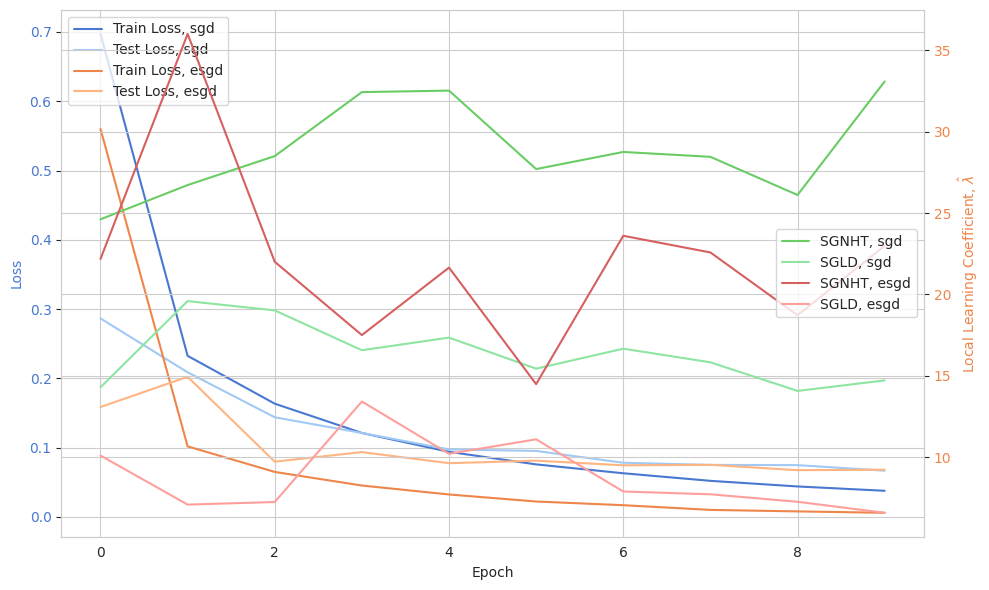

In [7]:
sns.set_style("whitegrid")

fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color=PRIMARY)
ax1.plot(train_losses["sgd"], label="Train Loss, sgd", color=PRIMARY)
ax1.plot(test_losses["sgd"], label="Test Loss, sgd", color=PRIMARY_LIGHT)

ax1.plot(train_losses["esgd"], label="Train Loss, esgd", color=SECONDARY)
ax1.plot(test_losses["esgd"], label="Test Loss, esgd", color=SECONDARY_LIGHT)
ax1.tick_params(axis="y", labelcolor=PRIMARY)
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.set_ylabel(r"Local Learning Coefficient, $\hat \lambda$", color=SECONDARY)
ax2.plot(rlct_sgd["sgnht"], label="SGNHT, sgd", color=TERTIARY)
ax2.plot(rlct_sgd["sgld"], label="SGLD, sgd", color=TERTIARY_LIGHT)

ax2.plot(rlct_esgd["sgnht"], label="SGNHT, esgd", color=QUATERNARY)
ax2.plot(rlct_esgd["sgld"], label="SGLD, esgd", color=QUATERNARY_LIGHT)
ax2.tick_params(axis="y", labelcolor=SECONDARY)
ax2.legend(loc="center right")

fig.tight_layout()
plt.show()